In [17]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.regularizers import l2

In [18]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [19]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [20]:
batch_size = 32
img_size = [180,180]

In [21]:
#training Dataset
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir_train,validation_split=0.8 ,subset='training',shuffle=True,
                                                     batch_size=batch_size,image_size=img_size,seed=123)

#Validation Dataset
valid_ds=tf.keras.utils.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset='validation',shuffle=True,
                                                     batch_size=batch_size,image_size=img_size,seed=123)

#Test Dataset for testing the final model
test_t = tf.keras.utils.image_dataset_from_directory(data_dir_test, shuffle=True,batch_size=batch_size,image_size=img_size)

Found 2239 files belonging to 9 classes.
Using 448 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [22]:
class_names = train_ds.class_names
print(class_names)
print(test_t.class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


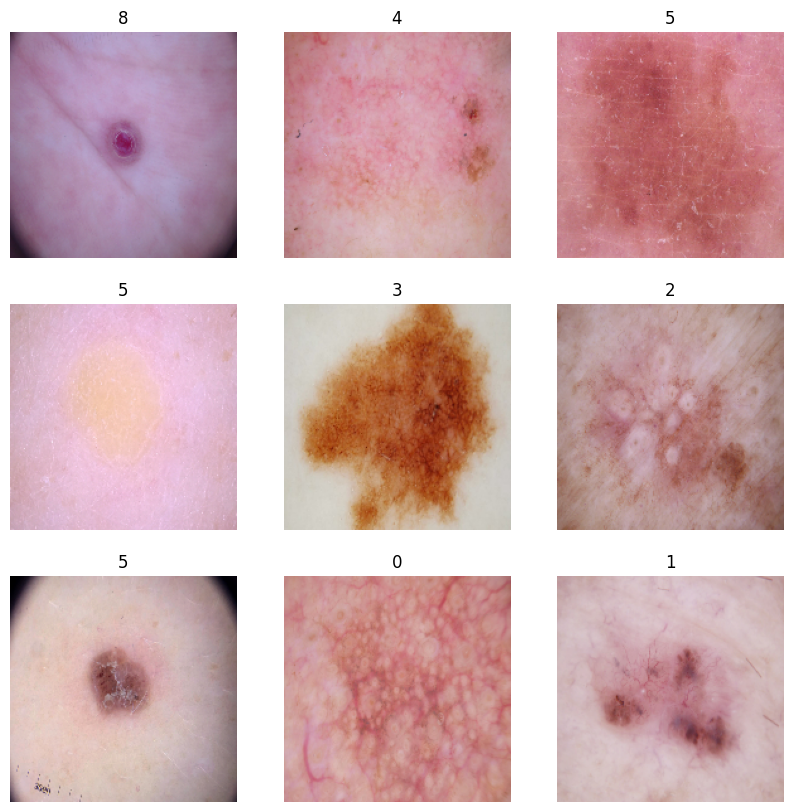

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Doing data Augmentation. In order to overcome the class imbalance


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

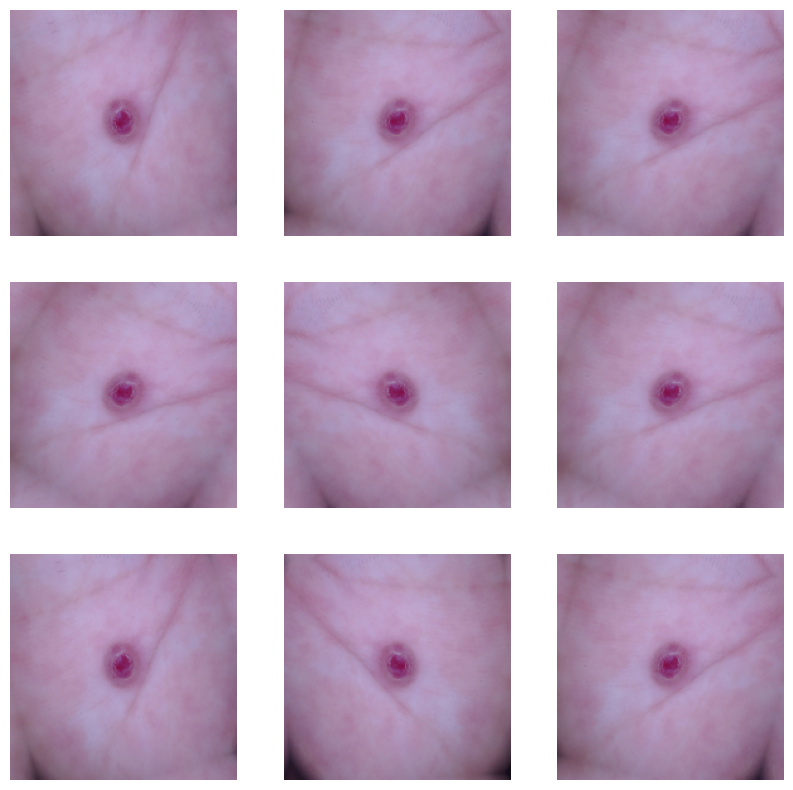

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)
test_t = test_t.prefetch(tf.data.AUTOTUNE)

In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))

In [ ]:
# summary of the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 178, 178, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 64)     256       
 hNormalization)                                      

In [ ]:
# compile
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(train_ds,
              batch_size = 32 ,
              epochs=20,
              validation_data=valid_ds,
              shuffle=True)

Epoch 1/20
56/56 [==============================] - 1258s 22s/step - loss: 27.1618 - accuracy: 0.2478 - val_loss: 31.0649 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 1191s 21s/step - loss: 12.4010 - accuracy: 0.3075 - val_loss: 14.1452 - val_accuracy: 0.1767
Epoch 3/20
56/56 [==============================] - 1193s 21s/step - loss: 11.9705 - accuracy: 0.3594 - val_loss: 12.8557 - val_accuracy: 0.3020
Epoch 4/20
56/56 [==============================] - 1190s 21s/step - loss: 11.6481 - accuracy: 0.4023 - val_loss: 12.4373 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 1195s 21s/step - loss: 11.3927 - accuracy: 0.4263 - val_loss: 14.2246 - val_accuracy: 0.3468
Epoch 6/20
56/56 [==============================] - 1178s 21s/step - loss: 11.1673 - accuracy: 0.4342 - val_loss: 11.3983 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 1175s 21s/step - loss: 10.8925 - accuracy: 0.4598 - val_loss: 11.4195 - val_ac

The accuracy of the model is 50 % for validation and in training its 52%. The model is fine but the accuracy is very low.
with epochs=20

Now we are using adam optimzer with higher inputs

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  #  residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Adding back residual
        previous_block_activation = x  # next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(9, activation='softmax')(x)
    return keras.Model(inputs, outputs)

image_size = (180,180)
model = make_model(input_shape=image_size + (3,), num_classes=9)

In [ ]:
#Compile
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(train_ds,
              batch_size = 32 ,
              epochs=20,
              validation_data=valid_ds,
              shuffle=True)

Epoch 1/20
56/56 [==============================] - 1318s 23s/step - loss: 1.8000 - accuracy: 0.3750 - val_loss: 2.1896 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 1239s 22s/step - loss: 1.5919 - accuracy: 0.4448 - val_loss: 2.2049 - val_accuracy: 0.0515
Epoch 3/20
56/56 [==============================] - 1237s 22s/step - loss: 1.5722 - accuracy: 0.4548 - val_loss: 2.2706 - val_accuracy: 0.0537
Epoch 4/20
56/56 [==============================] - 1232s 22s/step - loss: 1.4778 - accuracy: 0.4788 - val_loss: 2.3197 - val_accuracy: 0.0537
Epoch 5/20
56/56 [==============================] - 1224s 22s/step - loss: 1.4414 - accuracy: 0.4860 - val_loss: 2.4316 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 1208s 22s/step - loss: 1.3966 - accuracy: 0.4911 - val_loss: 2.5578 - val_accuracy: 0.0492
Epoch 7/20
56/56 [==============================] - 1213s 22s/step - loss: 1.3995 - accuracy: 0.4911 - val_loss: 3.3685 - val_accuracy: 0.0537

As we can see that the accuracy of the training increases but the accurancy of the validation decresed very much. Which tells us that the model is getting overfit.

Now we are reducing the number of inputs and also changed back to the sgd optimzer but we have increased the ephocs to 30.


In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.SeparableConv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))

In [ ]:
# summary of the model
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 activation_12 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 64)     256       
 hNormalization)                                                 
                                                                 
 separable_conv2d_3 (Separab  (None, 178, 178, 64)     4736      
 leConv2D)                                                       
                                                                 
 activation_13 (Activation)  (None, 178, 178, 64)      0         
                                                                 
 batch_normalization_9 (Batc  (None, 178, 178, 64)    

In [ ]:
#Compile
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(train_ds,
              batch_size = 32 ,
              epochs=30,
              validation_data=valid_ds,
              shuffle=True)

Epoch 1/30
14/14 [==============================] - 199s 14s/step - loss: 29.1487 - accuracy: 0.2098 - val_loss: 24.6663 - val_accuracy: 0.1924
Epoch 2/30
14/14 [==============================] - 188s 13s/step - loss: 12.6778 - accuracy: 0.3214 - val_loss: 16.9896 - val_accuracy: 0.1857
Epoch 3/30
14/14 [==============================] - 188s 13s/step - loss: 12.3884 - accuracy: 0.3192 - val_loss: 15.0399 - val_accuracy: 0.1834
Epoch 4/30
14/14 [==============================] - 188s 13s/step - loss: 12.0644 - accuracy: 0.3795 - val_loss: 16.1658 - val_accuracy: 0.2081
Epoch 5/30
14/14 [==============================] - 187s 13s/step - loss: 12.0196 - accuracy: 0.3973 - val_loss: 14.1157 - val_accuracy: 0.1946
Epoch 6/30
14/14 [==============================] - 187s 13s/step - loss: 11.8391 - accuracy: 0.4174 - val_loss: 14.3897 - val_accuracy: 0.1790
Epoch 7/30
14/14 [==============================] - 187s 13s/step - loss: 11.6780 - accuracy: 0.4688 - val_loss: 14.1670 - val_accuracy:

We can see that the model has increased the training accurancy and also the validation accuracy has been increased but the difference is much higher between the training accuracy and validation accuracy

Now we have again changed the optimzer to sgd to see any increase in the validation accuracy.Also we have changed the ephocs back to 20.


In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.SeparableConv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))

In [ ]:
#Compile
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(train_ds,
              batch_size = 32 ,
              epochs=20,
              validation_data=valid_ds,
              shuffle=True)

Epoch 1/20
14/14 [==============================] - 325s 23s/step - loss: 120.3591 - accuracy: 0.2857 - val_loss: 50.3749 - val_accuracy: 0.0403
Epoch 2/20
14/14 [==============================] - 281s 20s/step - loss: 76.5196 - accuracy: 0.3705 - val_loss: 61.6825 - val_accuracy: 0.0403
Epoch 3/20
14/14 [==============================] - 287s 20s/step - loss: 52.6753 - accuracy: 0.3348 - val_loss: 64.5057 - val_accuracy: 0.0537
Epoch 4/20
14/14 [==============================] - 258s 19s/step - loss: 43.6381 - accuracy: 0.2969 - val_loss: 62.8126 - val_accuracy: 0.0358
Epoch 5/20
14/14 [==============================] - 259s 19s/step - loss: 39.3687 - accuracy: 0.2746 - val_loss: 59.2884 - val_accuracy: 0.0403
Epoch 6/20
14/14 [==============================] - 224s 16s/step - loss: 33.8101 - accuracy: 0.3527 - val_loss: 55.2011 - val_accuracy: 0.1365
Epoch 7/20
14/14 [==============================] - 258s 19s/step - loss: 29.3467 - accuracy: 0.2946 - val_loss: 51.3624 - val_accuracy

This model gets overfitted